In [2]:
import os
import sys
sys.path.append("/home/psimmerl/mdc_analysis")
# sys.path.append("/home/psimmerl/mdc_analysis/src")

import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor
import numba as nb

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from histo_skim import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
    CUTS,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.rdf" #! BROKEN
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.rdf" #! BROKEN
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.rdf"
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.rdf"

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

USE_R2_LUMI = True

/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/psimmerl/mambaforge/envs/ROOT/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allocator_args.h" [optional] 

Welcome to JupyROOT 6.28/04


In [3]:
fdir_datacards = "../data/datacard_scan"
datacard_stats = [] #{}
for fn_datacard in os.listdir(fdir_datacards):
    if not( "datacard_ct" in fn_datacard and ".txt" in fn_datacard ):
        continue

    print(fn_datacard)
    ctau, min_met, max_met = fn_datacard[:-4].split("_")[1:4]
    min_met, max_met = int(min_met[-3:]), int(max_met[-3:])
    _read = lambda x: x.readline().rstrip("\n").split(" ")[2:]
    with open(fdir_datacards + "/" + fn_datacard) as ff_datacard:
        norm = float(_read(ff_datacard)[-1])
        ctau = float(_read(ff_datacard)[-1]) / 1000

        abcd_dphi = float(_read(ff_datacard)[-1])
        abcd_size = float(_read(ff_datacard)[-1])
        abcd_flip = bool(_read(ff_datacard)[-1])

        s2b, mylimit, mylimite = [float(x) for x in _read(ff_datacard)]
        datacard_stats.append([ctau, min_met, max_met, norm, abcd_dphi, abcd_size, abcd_flip, s2b, mylimit, mylimite])
        # print(f"{norm=}\n{ctau=}\n{abcd_dphi=}\n{abcd_size=}\n{abcd_flip=}\n{s2b=}\n{limit=}\n{limite=}")

        # print(ff_datacard)
    # print(fn_datacard)
datacard_stats = np.asarray(datacard_stats, dtype=float)

In [4]:
datacard_stats
""" plot low (split=max_met) and high (split=min_met) all vs x=split_met

split_met = 1 and split_met = min(limit)

 abcd_dPhi/flip | abcd_size
----------------+-----------
       abcd_s2b | limit

ctau_{min(limit)}

"""

PLOT_ERROR_BARS = True
PLOT_CTAU_VALUE = [1, None][0] # ctau value or none for best value

# *** #
if isinstance(PLOT_CTAU_VALUE, (int, float)):
    dcs = datacard_stats[:,0] == PLOT_CTAU_VALUE
else:
    raise
    idx = np.argmin(limits_r2[:,-1]).flat
dcs = datacard_stats[dcs]

idx = np.argsort(dcs[:,2])
idx = np.argsort(dcs[idx,1]) # I dont know if this works but doesnt matter
dcs = dcs[idx]

idx_r3 = (dcs[:,1] == 0) & (dcs[:,2] == 999)
idxl = (dcs[:,1] == 0) & (dcs[:,2] != 999)
idxh = (dcs[:,1] != 0) & (dcs[:,2] == 999)
# dcsh = np.argsort(dcs[:,1])
# ******************************************* #
# ******************************************* #
# ******************************************* #

canvas = rt.TCanvas("","",800,800)
canvas.Divide(2, 2)
# canvas.SetRightMargin(0.04)
# canvas.cd(1).SetLogx()
# canvas.cd(1).SetLogy()
# canvas.cd(1).SetGrid()

# legend = rt.TLegend(0.17, 0.17, 0.17+0.25, 0.17+0.25)
# legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)
# legend = rt.TLegend(0.55, 0.75, 0.93, 0.93)

mets = np.unique(dcs[:,1])
mets = np.asarray(mets, dtype=float)
mets = mets[mets != 0]


# *** #

names = [ ["Run 2", "Run 3", "Below ME_{T} Bounday", "Above ME_{T} Bounday"] ] * 4
print(names)
values = [
    [np.zeros_like(mets), np.asarray(len(mets)* [dcs[idx_r3,4]]), dcs[idxl,4], dcs[idxh,4]],
    [np.zeros_like(mets), np.asarray(len(mets)* [dcs[idx_r3,5]]), dcs[idxl,5], dcs[idxh,5]],
    [np.zeros_like(mets), np.asarray(len(mets)* [dcs[idx_r3,7]]), dcs[idxl,7], dcs[idxh,7]],
    [np.zeros_like(mets), np.asarray(len(mets)* [dcs[idx_r3,8]]), dcs[idxl,8], dcs[idxh,8]], 
]
errors = [
    [np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets)],
    [np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets)],
    [np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets)],
    [np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets), np.zeros_like(mets)], 
]
colors = [ [rt.kBlack, rt.kRed, rt.kAzure, rt.kOrange] ] * 4

tt0 = ";2-Category ME_{T} Boundary [GeV];"
titles = ["ABCD |#Delta#phi_{CSC,DT}| Boundary", "ABCD DT_{SIZE} Boundary", "S/#sqrt{B} in SR A", "limit"]

# *** # abcd_dPhi / flip

for it, tt in enumerate(titles):
    canvas.cd(it + 1).SetGrid()
    canvas.cd(it + 1).SetRightMargin(0.04)
#     (nl, nh), (vl, vh), (el, eh), (cl, ch)

    if it == 3:
        legend = rt.TLegend(0.2, 0.75, 0.6, 1)

    for igr in range(len(names[it])):
        gr = rt.TGraphErrors(len(mets), mets, values[it][igr], 0*mets, errors[it][igr])
        
        gr.SetName(names[it][igr])
        gr.SetTitle(tt0 + titles[it])

        gr.SetLineWidth(3)
        gr.SetMarkerSize(0.8)
        gr.SetLineColor(colors[it][igr])
        gr.SetMarkerColor(colors[it][igr])
        gr.SetFillColorAlpha(colors[it][igr], 0.3)
        if it == 0:
            gr.SetMaximum(np.pi)
            gr.SetMinimum(0)
        elif it == 1:
            gr.SetMaximum(100)
            gr.SetMinimum(0)
        elif it == 2:
            gr.SetMaximum(1.25 * 1000)
            gr.SetMinimum(0)
            # canvas.cd(it + 1).SetLogy()#rt.kTrue)
        elif it == 3:
            gr.SetMaximum(1)
            gr.SetMinimum(10**-4)
            canvas.cd(it + 1).SetLogy()#rt.kTrue)
            legend.AddEntry(gr, gr.GetName(), "L" + ("F" if PLOT_ERROR_BARS else ""))#P"


        # gr.Draw("same PE")
        gr.Draw(("same" if igr else "A") + " L3")
        gc.append(gr)


# *** #
legend.Draw()
canvas.Draw()

# dphi 50 100 etc

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
std_color_list

[1,
 2,
 4,
 8,
 6,
 28,
 43,
 7,
 25,
 36,
 30,
 40,
 42,
 49,
 46,
 38,
 32,
 800,
 600,
 900,
 870,
 840]

In [5]:
ff_run2_limits = "../data/BB_15_DTCSC.csv"
ff_run3_limits = "../data/my_limit_tree.csv"
# ff_run3_limits = "../data/split_met_limits_r3.csv"
# ff_run3_limits_combined = "../data/split_met_limits_combined_r3.csv"
ff_run3_limits_combined = "../data/my_limit_tree_combined.csv"

limits_r2 = []
with open(ff_run2_limits, "r") as fin:
    for line in fin:
        if "ctau" in line:
            print(line.rstrip())
            continue
        limits_r2.append([float(x) for x in line.split(",")])

limits_r3 = []
with open(ff_run3_limits, "r") as fin:
    for line in fin:
        if "ctau" in line:
            print(line.rstrip())
            continue
        limits_r3.append([float(x) for x in line.split(" ")])

limits_combined_r3 = []
with open(ff_run3_limits_combined, "r") as fin:
    for line in fin:
        if "ctau" in line:
            print(line.rstrip())
            continue
        limits_combined_r3.append([float(x) for x in line.split(" ")])

limits_r2 = np.asarray(limits_r2, dtype=np.float32)
limits_r3 = np.asarray(limits_r3, dtype=np.float32)
limits_combined_r3 = np.asarray(limits_combined_r3, dtype=np.float32)

limits_r2 = limits_r2[np.argsort(limits_r2[:,0])]
limits_r3 = limits_r3[np.argsort(limits_r3[:,0])]
limits_combined_r3 = limits_combined_r3[np.argsort(limits_combined_r3[:,0])]

# limits_r2[:,0] /= 1#1000
limits_r3[:,0] /= 1000
limits_combined_r3[:,0] /= 1000

if USE_R2_LUMI:
    # limits_r2[:,1:] /= 1#(137/23)
    limits_r3[:,3:] /= (137/23)
    limits_combined_r3[:,2:] /= (137/23)

# limits_r2[:,1:] /= 1#(52/23)
# limits_r3[:,3:] /= (52/23)
# limits_combined_r3[:,2:] /= (52/23)

print(limits_r2.shape, limits_r3.shape, limits_combined_r3.shape)

ctau min_met max_met 2.5 16.0 50.0 84.0 97.5 limit
ctau split_met 2.5 16.0 50.0 84.0 97.5 limit
(55, 7) (5115, 9) (2530, 8)


In [10]:
limits_combined_r3[:3,:]

array([[9.9999998e-03, 3.5000000e+01, 1.5280407e+10, 2.0921719e+10,
        3.0323907e+10, 4.5795574e+10, 6.8096528e+10, 1.6846168e+10],
       [9.9999998e-03, 6.0000000e+01, 1.9096715e+10, 2.6108793e+10,
        3.8193431e+10, 5.7832481e+10, 8.6303269e+10, 1.4559466e+10],
       [9.9999998e-03, 9.5000000e+01, 8.8514232e+09, 1.2954849e+10,
        2.0788664e+10, 3.5041362e+10, 5.7272349e+10, 1.0903929e+10]],
      dtype=float32)

In [17]:
limits_r3[(limits_r3[:,0]==1)&(limits_r3[:,1]==0)&(limits_r3[:,2]==75)]

array([[1.0000000e+00, 0.0000000e+00, 7.5000000e+01, 7.5283082e-04,
        1.0533560e-03, 1.5542313e-03, 2.4153686e-03, 3.7693661e-03,
        1.5574880e-03]], dtype=float32)

In [18]:
limits_r3[(limits_r3[:,0]==1)&(limits_r3[:,1]==75)&(limits_r3[:,2]==999)]

array([[1.0000000e+00, 7.5000000e+01, 9.9900000e+02, 6.0660928e-04,
        1.0728376e-03, 2.0985403e-03, 4.1562985e-03, 6.3639712e-03,
        2.0932786e-03]], dtype=float32)

In [20]:
limits_combined_r3[(limits_combined_r3[:,0]==1)&(limits_combined_r3[:,1]==75)]

array([[1.0000000e+00, 7.5000000e+01, 5.8442500e-04, 8.1511127e-04,
        1.2263345e-03, 1.9449031e-03, 3.0182113e-03, 2.1578579e-03]],
      dtype=float32)

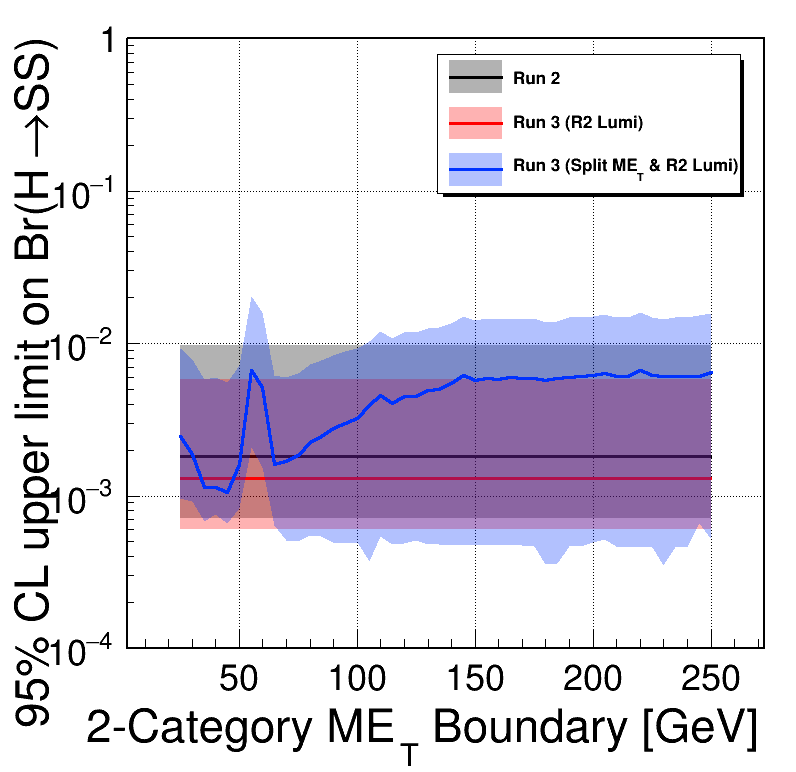

In [ ]:
PLOT_ERROR_BARS = True
PLOT_LIMIT_VALUE = [1, None][1] # ctau value or none for best value

canvas = rt.TCanvas("","",800,800)
canvas.SetRightMargin(0.04)
# canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()

# legend = rt.TLegend(0.17, 0.17, 0.17+0.25, 0.17+0.25)
# legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)
legend = rt.TLegend(0.55, 0.75, 0.93, 0.93)

mets = np.unique(limits_combined_r3[:,1])
mets = np.asarray(mets, dtype=float)

# *** # R2

if isinstance(PLOT_LIMIT_VALUE, (int, float)):
    idx = limits_r2[:,0] == PLOT_LIMIT_VALUE
else:
    idx = np.argmin(limits_r2[:,-1]).flat

_limits = np.array([limits_r2[idx][0] for i in range(len(mets))])

lmv = np.asarray(_limits[:,-1], dtype=float)
lml = np.asarray((_limits[:,-1] - _limits[:,1]) * PLOT_ERROR_BARS, dtype=float)
lmh = np.asarray((_limits[:,-1] + _limits[:,-2]) * PLOT_ERROR_BARS, dtype=float)

gr = rt.TGraphAsymmErrors(len(mets), mets, lmv, 0*mets, 0*mets, lml, lmh)
gr.SetName("Run 2")
gr.SetTitle(";2-Category ME_{T} Boundary [GeV];95% CL upper limit on Br(H#rightarrowSS)")

gr.SetLineWidth(3)
gr.SetMarkerSize(0.8)
gr.SetLineColor(rt.kBlack)
gr.SetMarkerColor(rt.kBlack)
gr.SetFillColorAlpha(rt.kBlack, 0.3)
gr.SetMaximum(1)
gr.SetMinimum(10**-4)

gr.Draw("AL3")
legend.AddEntry(gr, gr.GetName(), "L" + ("F" if PLOT_ERROR_BARS else ""))#P"
gc.append(gr)

# *** # R3

if isinstance(PLOT_LIMIT_VALUE, (int, float)):
    idx = limits_r3[:,0] == PLOT_LIMIT_VALUE & (limits_r3[:,1] == 0) & (limits_r3[:,2] == 999)
else:
    idx = np.argmin(limits_r3[:,-1] + 100*((limits_r3[:,1] != 0) & (limits_r3[:,2] != 999))).flat

_limits = np.array([limits_r3[idx][0] for i in range(len(mets))])

lmv = np.asarray(_limits[:,-1], dtype=float)
lml = np.asarray((_limits[:,-1] - _limits[:,3]) * PLOT_ERROR_BARS, dtype=float)
lmh = np.asarray((_limits[:,-1] + _limits[:,-2]) * PLOT_ERROR_BARS, dtype=float)

gr = rt.TGraphAsymmErrors(len(mets), mets, lmv, 0*mets, 0*mets, lml, lmh)
gr.SetName("Run 3 (R2 Lumi)")
gr.SetTitle(";2-Category ME_{T} Boundary [GeV];95% CL upper limit on Br(H#rightarrowSS)")

gr.SetLineWidth(3)
gr.SetMarkerSize(0.8)
gr.SetLineColor(rt.kRed)
gr.SetMarkerColor(rt.kRed)
gr.SetFillColorAlpha(rt.kRed, 0.3)
gr.SetMaximum(1)
gr.SetMinimum(10**-4)

gr.Draw("same L3")
legend.AddEntry(gr, gr.GetName(), "L" + ("F" if PLOT_ERROR_BARS else ""))#P"
gc.append(gr)


# *** # R3 Split & Combined

if isinstance(PLOT_LIMIT_VALUE, (int, float)):
    idx = limits_combined_r3[:,0] == PLOT_LIMIT_VALUE
    _limits = limits_combined_r3[idx]
else:
    _limits = []
    for met in mets:
        idx = limits_combined_r3[:,1] == met
        _limits.append(limits_combined_r3[idx][np.argmin(limits_combined_r3[idx,-1])])
    _limits = np.array(_limits, dtype=float)

lmv = np.asarray(_limits[:,-1] * 1.0, dtype=float)
lml = np.asarray((_limits[:,-1] - _limits[:,2]) * PLOT_ERROR_BARS, dtype=float)
lmh = np.asarray((_limits[:,-1] + _limits[:,-2]) * PLOT_ERROR_BARS, dtype=float)

gr = rt.TGraphAsymmErrors(len(mets), mets, lmv, 0*mets, 0*mets, lml, lmh)
gr.SetName("Run 3 (Split ME_{T} & R2 Lumi)")
gr.SetTitle(";2-Category ME_{T} Boundary [GeV];95% CL upper limit on Br(H#rightarrowSS)")

gr.SetLineWidth(3)
gr.SetMarkerSize(0.8)
gr.SetLineColor(rt.kAzure)
gr.SetMarkerColor(rt.kAzure)
gr.SetFillColorAlpha(rt.kAzure, 0.3)
gr.SetMaximum(1)
gr.SetMinimum(10**-4)

# gr.Draw("same PE")
gr.Draw("same L3")
legend.AddEntry(gr, gr.GetName(), "L" + ("F" if PLOT_ERROR_BARS else ""))#P"
gc.append(gr)

# *** #
legend.Draw()
canvas.Draw()


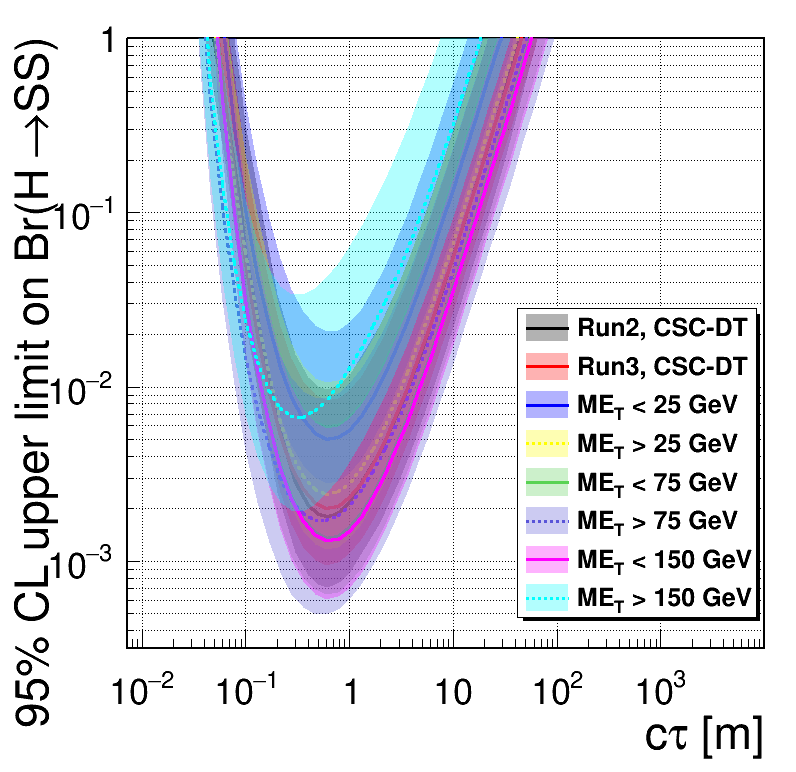

In [ ]:
PLOT_ERROR_BARS = True

canvas = rt.TCanvas("","",800,800)
canvas.SetRightMargin(0.04)
canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()

# legend = rt.TLegend(0.17, 0.17, 0.17+0.25, 0.17+0.25)
# legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)
legend = rt.TLegend(0.65, 0.2, 0.95, 0.6)

# **** #
ct_r2 = limits_r2[:,0]
ctl_r2, cth_r2 = 0*ct_r2, 0*ct_r2
lm_r2 = limits_r2[:,-1]
lml_r2 = (limits_r2[:,-1] - limits_r2[:,1]) * PLOT_ERROR_BARS
lmh_r2 = (limits_r2[:,5] + limits_r2[:,-1]) * PLOT_ERROR_BARS
# lmh_r2 = (limits_r2[:,5] - limits_r2[:,-1]) * PLOT_ERROR_BARS
##
idxs_met = (limits_r3[:,1] == 0) & (limits_r3[:,2] == 999)
ct_r3 = limits_r3[idxs_met,0]
ctl_r3, cth_r3 = 0*ct_r3, 0*ct_r3
lm_r3 = limits_r3[idxs_met,-1]
lml_r3 = (limits_r3[idxs_met,-1] - limits_r3[idxs_met,3]) * PLOT_ERROR_BARS
lmh_r3 = (limits_r3[idxs_met,7] + limits_r3[idxs_met,-1]) * PLOT_ERROR_BARS
# lmh_r3 = (limits_r3[idxs_met,7] - limits_r3[idxs_met,-1]) * PLOT_ERROR_BARS

#! I have no idea why i have to do this !#
ct_r2, lm_r2, ctl_r2, cth_r2, lml_r2, lmh_r2 = 1.0*ct_r2, 1.0*lm_r2, 1.0*ctl_r2, 1.0*cth_r2, 1.0*lml_r2, 1.0*lmh_r2
# ct_r3, lm_r3, ctl_r3, cth_r3, lml_r3, lmh_r3 = 1.0*ct_r3, 1.0*lm_r3, 1.0*ctl_r3, 1.0*cth_r3, 1.0*lml_r3, 1.0*lmh_r3
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

grs = [rt.TGraphAsymmErrors(len(ct_r2), ct_r2, lm_r2, ctl_r2, cth_r2, lml_r2, lmh_r2),
       rt.TGraphAsymmErrors(len(ct_r3), ct_r3, lm_r3, ctl_r3, cth_r3, lml_r3, lmh_r3)]

for igr, gr in enumerate(grs):
    gr.SetName("Run" + ("3" if igr else "2") + ", CSC-DT")
    gr.SetLineColor(std_color_list[igr])
# **** #

c_offset = len(grs)
# mets = np.unique(limits_r3[:,1])
# mets = mets[(0 < mets) & (mets < 999)]
# mets = [75]
# mets = [25, 50, 75, 100, 150]
mets = [25, 75, 150]
for imet, met in enumerate(mets):#[25, 50, 75])
    for i in range(2):
        if i == 0:
            idx = (limits_r3[:,1] == 0) & (limits_r3[:,2] == met)
        else:            
            idx = (limits_r3[:,1] == met) & (limits_r3[:,2] == 999)

        ct = limits_r3[idx,0]
        ctl, cth = 0*ct, 0*ct
        lm = limits_r3[idx,-1]
        lml = (limits_r3[idx,-1] - limits_r3[idx,3]) * PLOT_ERROR_BARS
        lmh = (limits_r3[idx,7] + limits_r3[idx,-1]) * PLOT_ERROR_BARS
        # lmh = (limits_r3[idx,7] - limits_r3[idx,-1]) * PLOT_ERROR_BARS

        # lml *= (limits_r3[idx,-1] > limits_r3[idx,3]) * (limits_r3[idx,7] > limits_r3[idx,-1])
        # lmh *= (limits_r3[idx,-1] > limits_r3[idx,3]) * (limits_r3[idx,7] > limits_r3[idx,-1])

        gr = rt.TGraphAsymmErrors(len(ct), ct, lm, ctl, cth, lml, lmh)
        gr.SetName(f"ME_{{T}} > {met} GeV" if i else f"ME_{{T}} < {met} GeV")
        gr.SetLineColor(std_color_list[imet + c_offset] + (i if PLOT_ERROR_BARS else 0))
        gr.SetLineStyle(rt.kDashed if i else rt.kSolid)

        grs.append(gr)

for igr, gr in enumerate(grs):
    gr.SetMaximum(1)
    gr.SetMinimum(10**-3.5)
    # gr.GetXaxis().SetLimits(1e-2, 1e2)

    gr.SetTitle(";c#tau [m];95% CL upper limit on Br(H#rightarrowSS)")
    gr.SetLineWidth(3)
    gr.SetMarkerColor(gr.GetLineColor())
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)

    le = legend.AddEntry(gr, gr.GetName(), "L" + ("F" if PLOT_ERROR_BARS else ""))#P"
    gr.Draw(("" if igr else "A") + "L3")#P"

legend.Draw()
canvas.Draw()


In [ ]:
PLOT_ERROR_BARS = True

canvas = rt.TCanvas("","",800,800)
canvas.SetRightMargin(0.04)
canvas.cd(1).SetLogx()
canvas.cd(1).SetLogy()
canvas.cd(1).SetGrid()

# legend = rt.TLegend(0.17, 0.17, 0.17+0.25, 0.17+0.25)
# legend = rt.TLegend(0.6, 0.2, 0.95, 0.4)
legend = rt.TLegend(0.6, 0.2, 0.95, 0.6)

# **** #
ct_r2 = limits_r2[:,0]
ctl_r2, cth_r2 = 0*ct_r2, 0*ct_r2
lm_r2 = limits_r2[:,-1]
lml_r2 = (limits_r2[:,-1] - limits_r2[:,1]) * PLOT_ERROR_BARS
lmh_r2 = (limits_r2[:,5] + limits_r2[:,-1]) * PLOT_ERROR_BARS
# lmh_r2 = (limits_r2[:,5] - limits_r2[:,-1]) * PLOT_ERROR_BARS
##
idxs_met = (limits_r3[:,1] == 0) & (limits_r3[:,2] == 999)
ct_r3 = limits_r3[idxs_met,0]
ctl_r3, cth_r3 = 0*ct_r3, 0*ct_r3
lm_r3 = limits_r3[idxs_met,-1]
lml_r3 = (limits_r3[idxs_met,-1] - limits_r3[idxs_met,3]) * PLOT_ERROR_BARS
lmh_r3 = (limits_r3[idxs_met,7] + limits_r3[idxs_met,-1]) * PLOT_ERROR_BARS
# lmh_r3 = (limits_r3[idxs_met,7] - limits_r3[idxs_met,-1]) * PLOT_ERROR_BARS

#! I have no idea why i have to do this !#
ct_r2, lm_r2, ctl_r2, cth_r2, lml_r2, lmh_r2 = 1.0*ct_r2, 1.0*lm_r2, 1.0*ctl_r2, 1.0*cth_r2, 1.0*lml_r2, 1.0*lmh_r2
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

grs = [rt.TGraphAsymmErrors(len(ct_r2), ct_r2, lm_r2, ctl_r2, cth_r2, lml_r2, lmh_r2),
       rt.TGraphAsymmErrors(len(ct_r3), ct_r3, lm_r3, ctl_r3, cth_r3, lml_r3, lmh_r3)]

for igr, gr in enumerate(grs):
    gr.SetName("Run" + ("3" if igr else "2") + " CSC-DT")
    gr.SetLineColor(std_color_list[igr])
# **** #

c_offset = len(grs)
mets = np.unique(limits_combined_r3[:,1])
mets = mets[(0 < mets) & (mets < 999)]
mets = [25, 50, 75]#, 50, 75]
# mets = [25, 50, 75, 100, 150]
# mets = [25, 75, 150]
# mets = [110, 115, 120, 125]
for imet, met in enumerate(mets):#[25, 50, 75])
        idx = limits_combined_r3[:,1] == met

        ct = limits_combined_r3[idx,0]
        ctl, cth = 0*ct, 0*ct
        lm = limits_combined_r3[idx,-1]
        lml = (limits_combined_r3[idx,-1] - limits_combined_r3[idx,2]) * PLOT_ERROR_BARS
        lmh = (limits_combined_r3[idx,6] + limits_combined_r3[idx,-1]) * PLOT_ERROR_BARS
        # lmh = (limits_combined_r3[idx,6] - limits_combined_r3[idx,-1]) * PLOT_ERROR_BARS

        # lml *= (limits_combined_r3[idx,-1] > limits_combined_r3[idx,2]) * (limits_combined_r3[idx,6] > limits_combined_r3[idx,-1])
        # lmh *= (limits_combined_r3[idx,-1] > limits_combined_r3[idx,2]) * (limits_combined_r3[idx,6] > limits_combined_r3[idx,-1])

        # if (lml < 0).any() or (lmh < 0).any():
        #      print(f"MET CATEGORY {met} FAILED -- SKIPPING")
        #      continue

        gr = rt.TGraphAsymmErrors(len(ct), ct, lm, ctl, cth, lml, lmh)
        gr.SetName(f"Combined ME_{{T}} = {met} GeV")
        gr.SetLineColor(std_color_list[imet + c_offset])# + i)

        grs.append(gr)

for igr, gr in enumerate(grs):
    gr.SetMaximum(1)
    gr.SetMinimum(10**-3.5)
    # gr.GetXaxis().SetLimits(1e-2, 1e2)

    gr.SetTitle(";c#tau [m];95% CL upper limit on Br(H#rightarrowSS)")
    gr.SetLineWidth(3)
    gr.SetMarkerColor(gr.GetLineColor())
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)

    le = legend.AddEntry(gr, gr.GetName(), "L" + ("F" if PLOT_ERROR_BARS else ""))#P"
    gr.Draw(("" if igr else "A") + "L3")#P"

legend.Draw()
canvas.Draw()



NameError: name 'rt' is not defined

In [ ]:
17 * 245**(1/2), 30 * 708**(1/2)

(266.092089322475, 798.2480817390042)

In [ ]:
r2_limit = limits_r2[limits_r2[:,0]==1][:,-1][0]
print(f"Run 2: {100*r2_limit:.2f}%")
r3_limit = limits_combined_r3[(limits_combined_r3[:,0]==1) & (limits_combined_r3[:,1]==25)][:,-1][0]
print(f"Run 3: {100*r3_limit:.2f}%")
print(f"Improvement: {r2_limit/r3_limit:.2f}")


Run 2: 0.22%
Run 3: 0.29%
Improvement: 0.75
